In [1]:
###########################################################
# Imports
###########################################################

import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

import HigherTierModel
import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
# trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_*.npz')
# trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_*_track_noPrimaries_wCutInfo_extraVar_NEW.npz')

print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_2_track_noPrimaries_wCutInfo_extraVar_NEW.npz', '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_1_track_noPrimaries_wCutInfo_extraVar_NEW.npz', '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries_wCutInfo_extraVar_NEW.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 5
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 79))
variables_test = np.empty((0, 79))

# Truth
y_train = np.empty((0, 4))
y_test = np.empty((0, 4))
trueParentChildLink_train = np.empty((0), dtype='int')
trueParentChildLink_test = np.empty((0), dtype='int')
trueChildVisibleGeneration_train = np.empty((0), dtype='int')
trueChildVisibleGeneration_test = np.empty((0), dtype='int')
trainingCutSep_train = np.empty((0), dtype='float')
trainingCutSep_test = np.empty((0), dtype='float')
trainingCutDoesConnect_train = np.empty((0), dtype='float')
trainingCutDoesConnect_test = np.empty((0), dtype='float')
trainingCutL_train = np.empty((0), dtype='float')
trainingCutL_test = np.empty((0), dtype='float')
trainingCutT_train = np.empty((0), dtype='float')
trainingCutT_test = np.empty((0), dtype='float')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    trueParentChildLink_train = np.concatenate((trueParentChildLink_train, data['trueParentChildLink_train']), axis=0)
    trueParentChildLink_test = np.concatenate((trueParentChildLink_test, data['trueParentChildLink_test']), axis=0)
    trueChildVisibleGeneration_train = np.concatenate((trueChildVisibleGeneration_train, data['trueChildVisibleGeneration_train']), axis=0)
    trueChildVisibleGeneration_test = np.concatenate((trueChildVisibleGeneration_test, data['trueChildVisibleGeneration_test']), axis=0)
    trainingCutSep_train = np.concatenate((trainingCutSep_train, data['trainingCutSep_train']), axis=0)
    trainingCutSep_test = np.concatenate((trainingCutSep_test, data['trainingCutSep_test']), axis=0)
    trainingCutDoesConnect_train = np.concatenate((trainingCutDoesConnect_train, data['trainingCutDoesConnect_train']), axis=0)
    trainingCutDoesConnect_test = np.concatenate((trainingCutDoesConnect_test, data['trainingCutDoesConnect_test']), axis=0)
    trainingCutL_train = np.concatenate((trainingCutL_train, data['trainingCutL_train']), axis=0)
    trainingCutL_test = np.concatenate((trainingCutL_test, data['trainingCutL_test']), axis=0)
    trainingCutT_train = np.concatenate((trainingCutT_train, data['trainingCutT_train']), axis=0)
    trainingCutT_test = np.concatenate((trainingCutT_test, data['trainingCutT_test']), axis=0)

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_2_track_noPrimaries_wCutInfo_extraVar_NEW.npz , This may take a while...
Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_1_track_noPrimaries_wCutInfo_extraVar_NEW.npz , This may take a while...
Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries_wCutInfo_extraVar_NEW.npz , This may take a while...


In [5]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)
print('trueChildVisibleGeneration_train.shape:', trueChildVisibleGeneration_train.shape)
print('trueChildVisibleGeneration_test.shape:', trueChildVisibleGeneration_test.shape)
print('trainingCutSep_train.shape:', trainingCutSep_train.shape)
print('trainingCutSep_test.shape:', trainingCutSep_test.shape)
print('trainingCutDoesConnect_train.shape:', trainingCutDoesConnect_train.shape)
print('trainingCutDoesConnect_test.shape:', trainingCutDoesConnect_test.shape)
print('trainingCutL_train.shape:', trainingCutL_train.shape)
print('trainingCutL_test.shape:', trainingCutL_test.shape)
print('trainingCutT_train.shape:', trainingCutT_train.shape)
print('trainingCutT_test.shape:', trainingCutT_test.shape)

nVariables = variables_train.shape[1]
nLinks = y_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (1652864, 79)
variables_test.shape: (183650, 79)
y_train.shape: (1652864, 4)
y_test.shape: (183650, 4)
trueParentChildLink_train.shape: (1652864,)
trueParentChildLink_test.shape: (183650,)
trueChildVisibleGeneration_train.shape: (1652864,)
trueChildVisibleGeneration_test.shape: (183650,)
trainingCutSep_train.shape: (1652864,)
trainingCutSep_test.shape: (183650,)
trainingCutDoesConnect_train.shape: (1652864,)
trainingCutDoesConnect_test.shape: (183650,)
trainingCutL_train.shape: (1652864,)
trainingCutL_test.shape: (183650,)
trainingCutT_train.shape: (1652864,)
trainingCutT_test.shape: (183650,)


In [6]:
###########################################################
# Apply training cut topology mask
###########################################################

# These are inspired by hand-scanning :'(
MAX_TRAINING_CUT_SEP = 20.0
MIN_TRAINING_CUT_L = -100.0
MAX_TRAINING_CUT_L = 100.0
MAX_TRAINING_CUT_T = 40.0

######################
# training set first
######################
# Make mask
passTrainingCutSep_train = trainingCutSep_train < MAX_TRAINING_CUT_SEP
passTrainingCutDoesConnect_train = trainingCutDoesConnect_train == 1
passTrainingCutL_train = np.logical_and(trainingCutL_train > MIN_TRAINING_CUT_L, trainingCutL_train < MAX_TRAINING_CUT_L)
passTrainingCutT_train = trainingCutT_train < MAX_TRAINING_CUT_T
# passTrainingCuts_train = np.logical_or(passTrainingCutSep_train, np.logical_and(passTrainingCutL_train, passTrainingCutT_train))
passTrainingCuts_train = np.logical_or(passTrainingCutSep_train, np.logical_or(passTrainingCutDoesConnect_train, np.logical_and(passTrainingCutL_train, passTrainingCutT_train)))

# Mask the 1D variables... shape=(nEntries, )
trueChildVisibleGeneration_train = trueChildVisibleGeneration_train[passTrainingCuts_train]
trueParentChildLink_train = trueParentChildLink_train[passTrainingCuts_train]
trainingCutSep_train = trainingCutSep_train[passTrainingCuts_train] # Don't really need to do this as we're not using them again
trainingCutDoesConnect_train = trainingCutDoesConnect_train[passTrainingCuts_train] # Don't really need to do this as we're not using them again
trainingCutL_train = trainingCutL_train[passTrainingCuts_train]     # Don't really need to do this as we're not using them again
trainingCutT_train = trainingCutT_train[passTrainingCuts_train]     # Don't really need to do this as we're not using them again

# Mask the truth... shape=(nEntries, nLinks)
y_train = y_train[np.column_stack((passTrainingCuts_train, passTrainingCuts_train, passTrainingCuts_train, passTrainingCuts_train))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_train = variables_train[[[entry] * nVariables for entry in passTrainingCuts_train]].reshape(-1, nVariables)

######################
# now test set
######################
# Make mask
passTrainingCutSep_test = trainingCutSep_test < MAX_TRAINING_CUT_SEP
passTrainingCutDoesConnect_test = trainingCutDoesConnect_test == 1
passTrainingCutL_test = np.logical_and(trainingCutL_test > MIN_TRAINING_CUT_L, trainingCutL_test < MAX_TRAINING_CUT_L)
passTrainingCutT_test = trainingCutT_test < MAX_TRAINING_CUT_T
# passTrainingCuts_test = np.logical_or(passTrainingCutSep_test, np.logical_and(passTrainingCutL_test, passTrainingCutT_test))
passTrainingCuts_test = np.logical_or(passTrainingCutSep_test, np.logical_or(passTrainingCutDoesConnect_test, np.logical_and(passTrainingCutL_test, passTrainingCutT_test)))

# Mask the 1D variables... shape=(nEntries, )
trueChildVisibleGeneration_test = trueChildVisibleGeneration_test[passTrainingCuts_test]
trueParentChildLink_test = trueParentChildLink_test[passTrainingCuts_test]
trainingCutSep_test = trainingCutSep_test[passTrainingCuts_test] # Don't really need to do this as we're not using them again
trainingCutDoesConnect_test = trainingCutDoesConnect_test[passTrainingCuts_test] # Don't really need to do this as we're not using them again
trainingCutL_test = trainingCutL_test[passTrainingCuts_test]     # Don't really need to do this as we're not using them again
trainingCutT_test = trainingCutT_test[passTrainingCuts_test]     # Don't really need to do this as we're not using them again

# Mask the truth... shape=(nEntries, nLinks)
y_test = y_test[np.column_stack((passTrainingCuts_test, passTrainingCuts_test, passTrainingCuts_test, passTrainingCuts_test))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_test = variables_test[[[entry] * nVariables for entry in passTrainingCuts_test]].reshape(-1, nVariables)

In [7]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)
print('trueChildVisibleGeneration_train.shape:', trueChildVisibleGeneration_train.shape)
print('trueChildVisibleGeneration_test.shape:', trueChildVisibleGeneration_test.shape)
print('trainingCutSep_train.shape:', trainingCutSep_train.shape)
print('trainingCutSep_test.shape:', trainingCutSep_test.shape)
print('trainingCutDoesConnect_train.shape:', trainingCutDoesConnect_train.shape)
print('trainingCutDoesConnect_test.shape:', trainingCutDoesConnect_test.shape)
print('trainingCutL_train.shape:', trainingCutL_train.shape)
print('trainingCutL_test.shape:', trainingCutL_test.shape)
print('trainingCutT_train.shape:', trainingCutT_train.shape)
print('trainingCutT_test.shape:', trainingCutT_test.shape)


variables_train.shape: (836957, 79)
variables_test.shape: (92648, 79)
y_train.shape: (836957, 4)
y_test.shape: (92648, 4)
trueParentChildLink_train.shape: (836957,)
trueParentChildLink_test.shape: (92648,)
trueChildVisibleGeneration_train.shape: (836957,)
trueChildVisibleGeneration_test.shape: (92648,)
trainingCutSep_train.shape: (836957,)
trainingCutSep_test.shape: (92648,)
trainingCutDoesConnect_train.shape: (836957,)
trainingCutDoesConnect_test.shape: (92648,)
trainingCutL_train.shape: (836957,)
trainingCutL_test.shape: (92648,)
trainingCutT_train.shape: (836957,)
trainingCutT_test.shape: (92648,)


In [8]:
###########################################################
# Work out weights
###########################################################

n_secondary_child_true_links_train = np.count_nonzero(np.logical_and(trueParentChildLink_train == True, (trueChildVisibleGeneration_train == 3)))
n_secondary_child_false_links_train = np.count_nonzero(np.logical_and(trueParentChildLink_train == False, (trueChildVisibleGeneration_train == 3)))

n_higher_child_true_links_train = np.count_nonzero(np.logical_and(trueParentChildLink_train == True, (trueChildVisibleGeneration_train > 3)))
n_higher_child_false_links_train = np.count_nonzero(np.logical_and(trueParentChildLink_train == False, (trueChildVisibleGeneration_train > 3)))

print('n_secondary_child_true_links_train:', n_secondary_child_true_links_train)
print('n_secondary_child_false_links_train:', n_secondary_child_false_links_train)
print('n_higher_child_true_links_train:', n_higher_child_true_links_train)
print('n_higher_child_false_links_train:', n_higher_child_false_links_train)

maxCounts_train = max(n_secondary_child_true_links_train, n_secondary_child_false_links_train, n_higher_child_true_links_train, n_higher_child_false_links_train)

classWeights_train = {'secondary_child_true_links_train'  : maxCounts_train/n_secondary_child_true_links_train, \
                      'secondary_child_false_links_train' : maxCounts_train/n_secondary_child_false_links_train, \
                      'n_higher_child_true_links_train'   : maxCounts_train/n_higher_child_true_links_train, \
                      'n_higher_child_false_links_train' : maxCounts_train/n_higher_child_false_links_train, \
                     }

print('classWeights_train:', classWeights_train)

classWeights_train['secondary_child_true_links_train'] = round(classWeights_train['secondary_child_true_links_train'])
classWeights_train['secondary_child_false_links_train'] = round(classWeights_train['secondary_child_false_links_train'])
classWeights_train['n_higher_child_true_links_train'] = round(classWeights_train['n_higher_child_true_links_train'])
classWeights_train['n_higher_child_false_links_train'] = round(classWeights_train['n_higher_child_false_links_train'])

print('classWeights_train:', classWeights_train)


n_secondary_child_true_links_train: 178745
n_secondary_child_false_links_train: 516540
n_higher_child_true_links_train: 30247
n_higher_child_false_links_train: 111425
classWeights_train: {'secondary_child_true_links_train': 2.8898150997230694, 'secondary_child_false_links_train': 1.0, 'n_higher_child_true_links_train': 17.077396105398883, 'n_higher_child_false_links_train': 4.6357639667938075}
classWeights_train: {'secondary_child_true_links_train': 3, 'secondary_child_false_links_train': 1, 'n_higher_child_true_links_train': 17, 'n_higher_child_false_links_train': 5}


In [9]:
###########################################################
# Is test similar?
###########################################################

n_secondary_child_true_links_test = np.count_nonzero(np.logical_and(trueParentChildLink_test == True, (trueChildVisibleGeneration_test == 3)))
n_secondary_child_false_links_test = np.count_nonzero(np.logical_and(trueParentChildLink_test == False, (trueChildVisibleGeneration_test == 3)))

n_higher_child_true_links_test = np.count_nonzero(np.logical_and(trueParentChildLink_test == True, (trueChildVisibleGeneration_test > 3)))
n_higher_child_false_links_test = np.count_nonzero(np.logical_and(trueParentChildLink_test == False, (trueChildVisibleGeneration_test > 3)))

print('n_secondary_child_true_links_test:', n_secondary_child_true_links_test)
print('n_secondary_child_false_links_test:', n_secondary_child_false_links_test)
print('n_higher_child_true_links_test:', n_higher_child_true_links_test)
print('n_higher_child_false_links_test:', n_higher_child_false_links_test)

maxCounts_test = max(n_secondary_child_true_links_test, n_secondary_child_false_links_test, n_higher_child_true_links_test, n_higher_child_false_links_test)

classWeights_test = {'secondary_child_true_links_test'  : maxCounts_test/n_secondary_child_true_links_test, \
                     'secondary_child_false_links_test' : maxCounts_test/n_secondary_child_false_links_test, \
                     'n_higher_child_true_links_test'   : maxCounts_test/n_higher_child_true_links_test, \
                     'n_higher_child_false_links_test' : maxCounts_test/n_higher_child_false_links_test, \
                    }

print('classWeights_test:', classWeights_test)

classWeights_test['secondary_child_true_links_test'] = round(classWeights_test['secondary_child_true_links_test'])
classWeights_test['secondary_child_false_links_test'] = round(classWeights_test['secondary_child_false_links_test'])
classWeights_test['n_higher_child_true_links_test'] = round(classWeights_test['n_higher_child_true_links_test'])
classWeights_test['n_higher_child_false_links_test'] = round(classWeights_test['n_higher_child_false_links_test'])

print('classWeights_test:', classWeights_test)


n_secondary_child_true_links_test: 19917
n_secondary_child_false_links_test: 57249
n_higher_child_true_links_test: 3330
n_higher_child_false_links_test: 12152
classWeights_test: {'secondary_child_true_links_test': 2.8743786714866695, 'secondary_child_false_links_test': 1.0, 'n_higher_child_true_links_test': 17.191891891891892, 'n_higher_child_false_links_test': 4.711076366030283}
classWeights_test: {'secondary_child_true_links_test': 3, 'secondary_child_false_links_test': 1, 'n_higher_child_true_links_test': 17, 'n_higher_child_false_links_test': 5}


In [10]:
###########################################################
# Split it into four again
###########################################################

n_links = nLinks
n_global_vars = 3
n_link_vars = 19

i_end_of_global_vars = n_global_vars
i_target_start = variables_train.shape[1] - n_link_vars
i_rest_start = n_global_vars
i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))

# Training
input_0_train_temp = variables_train
input_1_train_temp = np.concatenate((input_0_train_temp[:,0:i_end_of_global_vars], input_0_train_temp[:,i_target_start:], input_0_train_temp[:,i_rest_start:i_rest_end]), axis=1)
input_2_train_temp = np.concatenate((input_1_train_temp[:,0:i_end_of_global_vars], input_1_train_temp[:,i_target_start:], input_1_train_temp[:,i_rest_start:i_rest_end]), axis=1)
input_3_train_temp = np.concatenate((input_2_train_temp[:,0:i_end_of_global_vars], input_2_train_temp[:,i_target_start:], input_2_train_temp[:,i_rest_start:i_rest_end]), axis=1)

y_0_train_temp = y_train[:,0]
y_1_train_temp = y_train[:,1]
y_2_train_temp = y_train[:,2]
y_3_train_temp = y_train[:,3]

trueParentChildLink_train_temp = trueParentChildLink_train

# Test
input_0_test_temp = variables_test
input_1_test_temp = np.concatenate((input_0_test_temp[:,0:i_end_of_global_vars], input_0_test_temp[:,i_target_start:], input_0_test_temp[:,i_rest_start:i_rest_end]), axis=1)
input_2_test_temp = np.concatenate((input_1_test_temp[:,0:i_end_of_global_vars], input_1_test_temp[:,i_target_start:], input_1_test_temp[:,i_rest_start:i_rest_end]), axis=1)
input_3_test_temp = np.concatenate((input_2_test_temp[:,0:i_end_of_global_vars], input_2_test_temp[:,i_target_start:], input_2_test_temp[:,i_rest_start:i_rest_end]), axis=1)

y_0_test_temp = y_test[:,0]
y_1_test_temp = y_test[:,1]
y_2_test_temp = y_test[:,2]
y_3_test_temp = y_test[:,3]

trueParentChildLink_test_temp = trueParentChildLink_test

In [11]:
###########################################################
# Mimic the weighting of the loss function
###########################################################

weight_train = np.zeros(trueParentChildLink_train_temp.shape, dtype='int')
weight_train[np.logical_and(trueParentChildLink_train_temp == True, trueChildVisibleGeneration_train == 3)] = classWeights_train['secondary_child_true_links_train']   # 7
weight_train[np.logical_and(trueParentChildLink_train_temp == True, trueChildVisibleGeneration_train > 3)] = classWeights_train['n_higher_child_true_links_train']     # 37
weight_train[np.logical_and(trueParentChildLink_train_temp == False, trueChildVisibleGeneration_train == 3)] = classWeights_train['secondary_child_false_links_train'] # 1
weight_train[np.logical_and(trueParentChildLink_train_temp == False, trueChildVisibleGeneration_train > 3)] = classWeights_train['n_higher_child_false_links_train']   # 4

weight_test = np.zeros(trueParentChildLink_test_temp.shape, dtype='int')
weight_test[np.logical_and(trueParentChildLink_test_temp == True, trueChildVisibleGeneration_test == 3)] = classWeights_train['secondary_child_true_links_train']   # 7
weight_test[np.logical_and(trueParentChildLink_test_temp == True, trueChildVisibleGeneration_test > 3)] = classWeights_train['n_higher_child_true_links_train']     # 37
weight_test[np.logical_and(trueParentChildLink_test_temp == False, trueChildVisibleGeneration_test == 3)] = classWeights_train['secondary_child_false_links_train'] # 1
weight_test[np.logical_and(trueParentChildLink_test_temp == False, trueChildVisibleGeneration_test > 3)] = classWeights_train['n_higher_child_false_links_train']   # 4

input_0_train = [input_0_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]
input_1_train = [input_1_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]
input_2_train = [input_2_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]
input_3_train = [input_3_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]
y_0_train = [y_0_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]
y_1_train = [y_1_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]
y_2_train = [y_2_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]
y_3_train = [y_3_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]
trueParentChildLink_train = [trueParentChildLink_train_temp[i] for i in range(trueParentChildLink_train.shape[0]) for _ in range(weight_train[i])]

input_0_test = [input_0_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]
input_1_test = [input_1_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]
input_2_test = [input_2_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]
input_3_test = [input_3_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]
y_0_test = [y_0_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]
y_1_test = [y_1_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]
y_2_test = [y_2_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]
y_3_test = [y_3_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]
trueParentChildLink_test = [trueParentChildLink_test_temp[i] for i in range(trueParentChildLink_test.shape[0]) for _ in range(weight_test[i])]

input_0_train = np.array(input_0_train)
input_1_train = np.array(input_1_train)
input_2_train = np.array(input_2_train)
input_3_train = np.array(input_3_train)
y_0_train = to_categorical(np.array(y_0_train), 3)
y_1_train = to_categorical(np.array(y_1_train), 3)
y_2_train = to_categorical(np.array(y_2_train), 3)
y_3_train = to_categorical(np.array(y_3_train), 3)
trueParentChildLink_train = np.array(trueParentChildLink_train)
    
input_0_test = np.array(input_0_test)
input_1_test = np.array(input_1_test)
input_2_test = np.array(input_2_test)
input_3_test = np.array(input_3_test)
y_0_test = to_categorical(np.array(y_0_test), 3)
y_1_test = to_categorical(np.array(y_1_test), 3)
y_2_test = to_categorical(np.array(y_2_test), 3)
y_3_test = to_categorical(np.array(y_3_test), 3)
trueParentChildLink_test = np.array(trueParentChildLink_test)



In [12]:
###########################################################
# Check shapes
###########################################################

print('input_0_train:', input_0_train.shape)
print('input_1_train:', input_1_train.shape)
print('input_2_train:', input_2_train.shape)
print('input_3_train:', input_3_train.shape)
print('y_0_train:', y_0_train.shape)
print('y_1_train:', y_1_train.shape)
print('y_2_train:', y_2_train.shape)
print('y_3_train:', y_3_train.shape)
print('trueParentChildLink_train:',trueParentChildLink_train.shape)

print('input_0_test:', input_0_test.shape)
print('input_1_test:', input_1_test.shape)
print('input_2_test:', input_2_test.shape)
print('input_3_test:', input_3_test.shape)
print('y_0_test:', y_0_test.shape)
print('y_1_test:', y_1_test.shape)
print('y_2_test:', y_2_test.shape)
print('y_3_test:', y_3_test.shape)
print('trueParentChildLink_train:',trueParentChildLink_test.shape)

input_0_train: (2124099, 79)
input_1_train: (2124099, 79)
input_2_train: (2124099, 79)
input_3_train: (2124099, 79)
y_0_train: (2124099, 3)
y_1_train: (2124099, 3)
y_2_train: (2124099, 3)
y_3_train: (2124099, 3)
trueParentChildLink_train: (2124099,)
input_0_test: (234370, 79)
input_1_test: (234370, 79)
input_2_test: (234370, 79)
input_3_test: (234370, 79)
y_0_test: (234370, 3)
y_1_test: (234370, 3)
y_2_test: (234370, 3)
y_3_test: (234370, 3)
trueParentChildLink_train: (234370,)


In [13]:
###########################################################
# Define the model and optimiser and compile the model
###########################################################

model_final = HigherTierModel.HigherTierGroupModel_tracks(nVariables, dropoutRate=0.5)
optimiser_final = optimizers.legacy.Adam(learning_rate=learningRate)
model_final.compile(optimizer=optimiser_final, metrics=['accuracy'], loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy', 'binary_crossentropy'])

In [14]:
# ###########################################################
# # Define class weights
# ###########################################################

# nTrue_final = np.count_nonzero(trueParentChildLink_train == 1)
# nBackground_final = np.count_nonzero(trueParentChildLink_train == 0)

# maxLinks = max(nTrue_final, nBackground_final)

# classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

# print('classWeights_final:', classWeights_final)

In [15]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_oneModel'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_final_prediction_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model_final.fit([input_0_train, input_1_train, input_2_train, input_3_train], [y_0_train, y_1_train, y_2_train, y_3_train, trueParentChildLink_train], \
                                validation_data=([input_0_test, input_1_test, input_2_test, input_3_test], [y_0_test, y_1_test, y_2_test, y_3_test, trueParentChildLink_test]), \
                                batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final)

Epoch 1/5
33186/33190 [============================>.] - ETA: 0s - loss: 2.1168 - orientation_0_loss: 0.4486 - orientation_1_loss: 0.4445 - orientation_2_loss: 0.4630 - orientation_3_loss: 0.4581 - final_prediction_loss: 0.3025 - orientation_0_accuracy: 0.8289 - orientation_1_accuracy: 0.8299 - orientation_2_accuracy: 0.8233 - orientation_3_accuracy: 0.8241 - final_prediction_accuracy: 0.8773
Epoch 1: val_final_prediction_accuracy improved from -inf to 0.89377, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_oneModel
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_oneModel/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_oneModel/assets


33190/33190 [==============================] - 104s 3ms/step - loss: 2.1168 - orientation_0_loss: 0.4486 - orientation_1_loss: 0.4445 - orientation_2_loss: 0.4630 - orientation_3_loss: 0.4581 - final_prediction_loss: 0.3025 - orientation_0_accuracy: 0.8289 - orientation_1_accuracy: 0.8299 - orientation_2_accuracy: 0.8233 - orientation_3_accuracy: 0.8241 - final_prediction_accuracy: 0.8773 - val_loss: 1.8069 - val_orientation_0_loss: 0.3617 - val_orientation_1_loss: 0.3942 - val_orientation_2_loss: 0.3810 - val_orientation_3_loss: 0.3737 - val_final_prediction_loss: 0.2963 - val_orientation_0_accuracy: 0.8659 - val_orientation_1_accuracy: 0.8594 - val_orientation_2_accuracy: 0.8616 - val_orientation_3_accuracy: 0.8667 - val_final_prediction_accuracy: 0.8938 - lr: 0.0010
Epoch 2/5
33189/33190 [============================>.] - ETA: 0s - loss: 1.8556 - orientation_0_loss: 0.3906 - orientation_1_loss: 0.3895 - orientation_2_loss: 0.4053 - orientation_3_loss: 0.3978 - final_prediction_loss:

INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_oneModel/assets


33190/33190 [==============================] - 88s 3ms/step - loss: 1.7888 - orientation_0_loss: 0.3764 - orientation_1_loss: 0.3750 - orientation_2_loss: 0.3880 - orientation_3_loss: 0.3835 - final_prediction_loss: 0.2659 - orientation_0_accuracy: 0.8587 - orientation_1_accuracy: 0.8582 - orientation_2_accuracy: 0.8539 - orientation_3_accuracy: 0.8559 - final_prediction_accuracy: 0.8925 - val_loss: 1.7303 - val_orientation_0_loss: 0.3410 - val_orientation_1_loss: 0.3570 - val_orientation_2_loss: 0.3581 - val_orientation_3_loss: 0.3620 - val_final_prediction_loss: 0.3123 - val_orientation_0_accuracy: 0.8761 - val_orientation_1_accuracy: 0.8711 - val_orientation_2_accuracy: 0.8729 - val_orientation_3_accuracy: 0.8712 - val_final_prediction_accuracy: 0.8942 - lr: 0.0010
Epoch 4/5
33186/33190 [============================>.] - ETA: 0s - loss: 1.7518 - orientation_0_loss: 0.3684 - orientation_1_loss: 0.3668 - orientation_2_loss: 0.3790 - orientation_3_loss: 0.3757 - final_prediction_loss: 

dict_keys(['loss', 'orientation_0_loss', 'orientation_1_loss', 'orientation_2_loss', 'orientation_3_loss', 'final_prediction_loss', 'orientation_0_accuracy', 'orientation_1_accuracy', 'orientation_2_accuracy', 'orientation_3_accuracy', 'final_prediction_accuracy', 'val_loss', 'val_orientation_0_loss', 'val_orientation_1_loss', 'val_orientation_2_loss', 'val_orientation_3_loss', 'val_final_prediction_loss', 'val_orientation_0_accuracy', 'val_orientation_1_accuracy', 'val_orientation_2_accuracy', 'val_orientation_3_accuracy', 'val_final_prediction_accuracy', 'lr'])


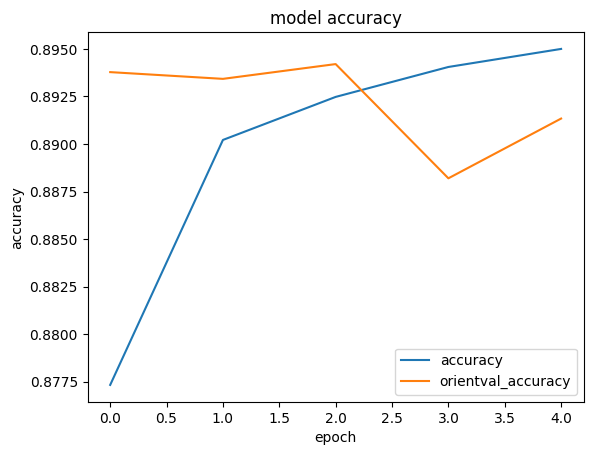

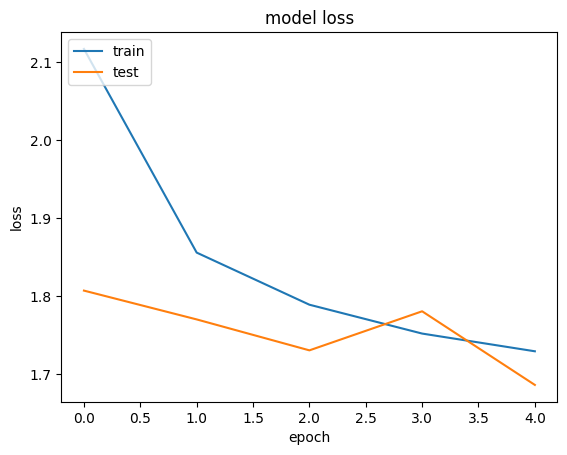

In [16]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['final_prediction_accuracy'])
plt.plot(history_final.history['val_final_prediction_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model_final.predict([input_0_train, input_1_train, input_2_train, input_2_train])
y_pred_final_test = model_final.predict([input_0_test, input_1_test, input_2_test, input_3_test])

7325/7325 [==============================] - 5s 670us/step


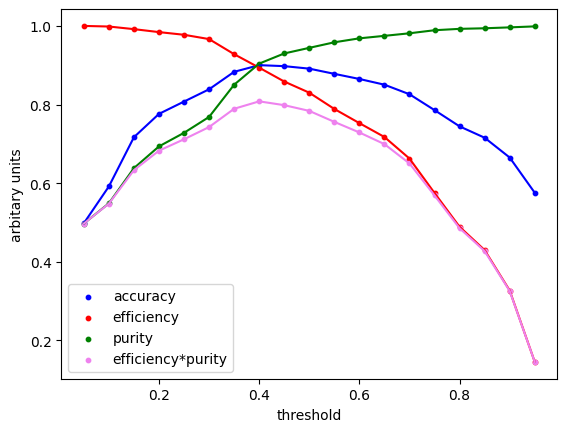

optimal_threshold_metric: 0.4


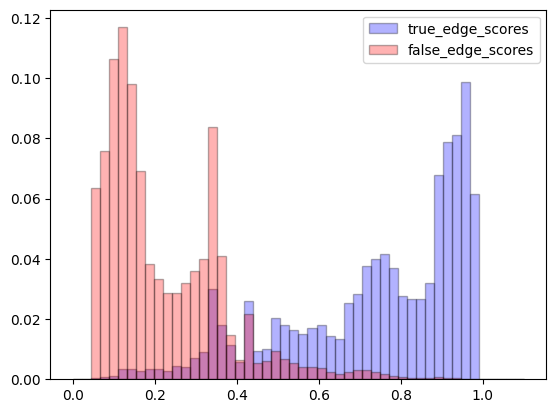

[[112303   5706]
 [ 19762  96599]]
[[106980  11029]
 [ 12354 104007]]


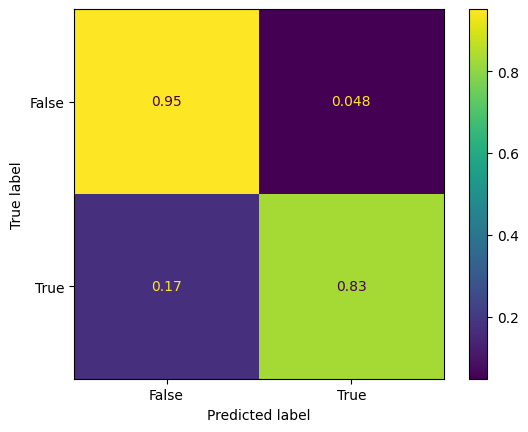

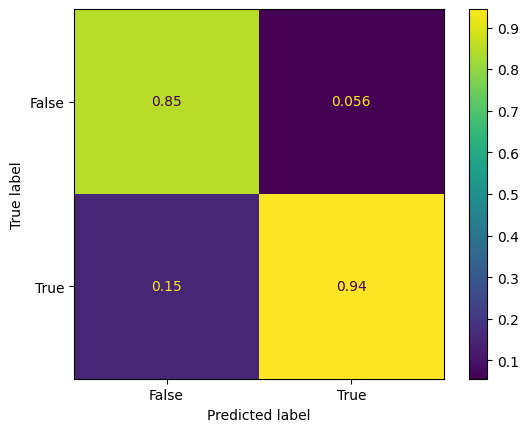

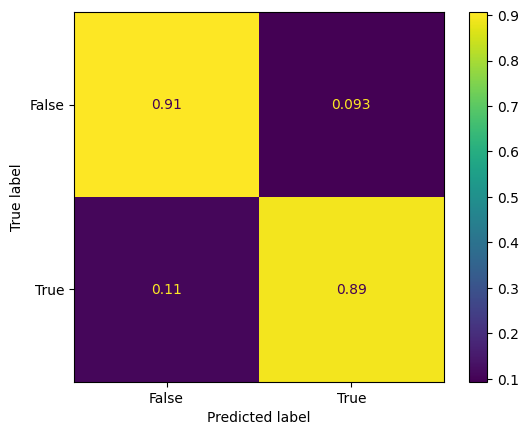

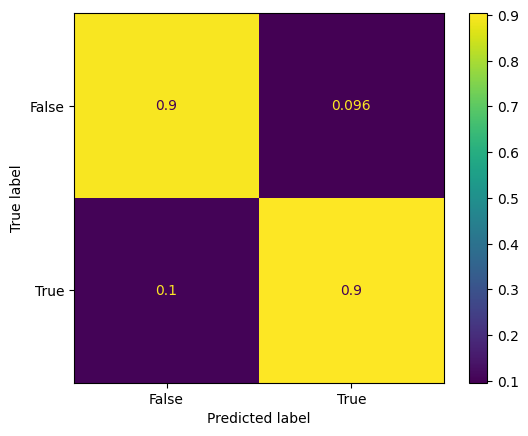

In [18]:
#######################################
# Plot final link prediction
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test[4], trueParentChildLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

#PerformanceFuncs.plot_scores(y_pred_final_train[4], trueParentChildLink_train)
PerformanceFuncs.plot_scores(y_pred_final_test[4], trueParentChildLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test[4], trueParentChildLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test[4], trueParentChildLink_test, optimal_threshold_metric)
